## MLND Capstone :: Carvana Image Masking Challenge

In [1]:
import time

import numpy as np
import pandas as pd
from scipy import ndimage
from tqdm import tqdm

from matplotlib import pyplot as plt
from keras.preprocessing.image import array_to_img, img_to_array, load_img, ImageDataGenerator

PROJECT_PATH = '.'
INPUT_PATH = PROJECT_PATH + '/input'

TRAIN_MASKS_CSV_PATH = INPUT_PATH + '/train_masks.csv'
TRAIN_PATH = INPUT_PATH + '/train'
TRAIN_MASKS_PATH = INPUT_PATH + '/train_masks'

Using TensorFlow backend.


In [2]:
def read_train_masks():
    global train_masks
    train_masks = pd.read_csv(TRAIN_MASKS_CSV_PATH)
    print(train_masks.head())

read_train_masks()

                   img                                           rle_mask
0  00087a6bd4dc_01.jpg  879386 40 881253 141 883140 205 885009 17 8850...
1  00087a6bd4dc_02.jpg  873779 4 875695 7 877612 9 879528 12 881267 15...
2  00087a6bd4dc_03.jpg  864300 9 866217 13 868134 15 870051 16 871969 ...
3  00087a6bd4dc_04.jpg  879735 20 881650 26 883315 92 883564 30 885208...
4  00087a6bd4dc_05.jpg  883365 74 883638 28 885262 119 885550 34 88716...


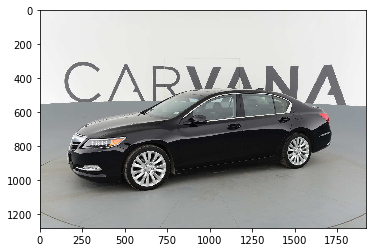

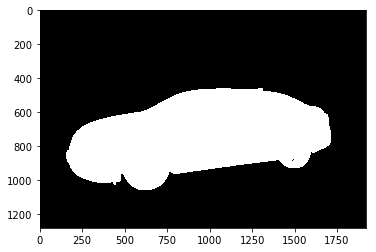

In [11]:
def read_mask_image(car_code, angle_code):
    mask_img_path = TRAIN_MASKS_PATH + '/' + car_code + '_' + angle_code + '_mask.gif';
    mask_img = ndimage.imread(mask_img_path, mode = 'L')
    mask_img[mask_img <= 127] = 0
    mask_img[mask_img > 127] = 1
    return mask_img

def show_mask_image(car_code, angle_code):
    mask_img = read_mask_image(car_code, angle_code)
    plt.imshow(mask_img, cmap = 'Greys_r')
    plt.show()

def read_image(car_code, angle_code):
    car_img_path = TRAIN_PATH + '/' + car_code + '_' + angle_code + '.jpg'
    car_img = ndimage.imread(car_img_path)
#     car_img = load_img(car_img_path)
#     car_img = img_to_array(car_img)
    return car_img

def show_image(car_code, angle_code):
    car_img = read_image(car_code, angle_code)    
    plt.imshow(car_img)
    plt.show()

show_image('00087a6bd4dc', '04')    
show_mask_image('00087a6bd4dc', '04')

In [5]:
# https://www.kaggle.com/stainsby/fast-tested-rle
def rle_encode(mask_image):
    pixels = mask_image.flatten()
    # We avoid issues with '1' at the start or end (at the corners of 
    # the original image) by setting those pixels to '0' explicitly.
    # We do not expect these to be non-zero for an accurate mask, 
    # so this should not harm the score.
    pixels[0] = 0
    pixels[-1] = 0
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 2
    runs[1::2] = runs[1::2] - runs[:-1:2]
    return runs

def rle_to_string(runs):
    return ' '.join(str(x) for x in runs)


def test_rle_encode():
    test_mask = np.asarray([[0, 0, 0, 0], [0, 0, 1, 1], [0, 0, 1, 1], [0, 0, 0, 0]])
    assert rle_to_string(rle_encode(test_mask)) == '7 2 11 2'
    num_masks = len(train_masks['img'])
    print('Verfiying RLE encoding on', num_masks, 'masks ...')
    time_read = 0.0 # seconds
    time_rle = 0.0 # seconds
    time_stringify = 0.0 # seconds
    for mask_idx in range(num_masks):
        img_file_name = train_masks.loc[mask_idx, 'img']
        car_code, angle_code = img_file_name.split('.')[0].split('_')
        t0 = time.clock()
        mask_image = read_mask_image(car_code, angle_code)
        time_read += time.clock() - t0
        t0 = time.clock()
        rle_truth_str = train_masks.loc[mask_idx, 'rle_mask']
        rle = rle_encode(mask_image)
        time_rle += time.clock() - t0
        t0 = time.clock()
        rle_str = rle_to_string(rle)
        time_stringify += time.clock() - t0
        assert rle_str == rle_truth_str
        if mask_idx and (mask_idx % 500) == 0:
            print('  ..', mask_idx, 'tested ..')
    print('Time spent reading mask images:', time_read, 's, =>', \
            1000*(time_read/num_masks), 'ms per mask.')
    print('Time spent RLE encoding masks:', time_rle, 's, =>', \
            1000*(time_rle/num_masks), 'ms per mask.')
    print('Time spent stringifying RLEs:', time_stringify, 's, =>', \
            1000*(time_stringify/num_masks), 'ms per mask.')


test_rle_encode()

Verfiying RLE encoding on 5088 masks ...
  .. 500 tested ..
  .. 1000 tested ..
  .. 1500 tested ..
  .. 2000 tested ..
  .. 2500 tested ..
  .. 3000 tested ..
  .. 3500 tested ..
  .. 4000 tested ..
  .. 4500 tested ..
  .. 5000 tested ..
Time spent reading mask images: 123.16060843318338 s, => 24.206094424760884 ms per mask.
Time spent RLE encoding masks: 20.111810592333217 s, => 3.9527929623296414 ms per mask.
Time spent stringifying RLEs: 16.05239496446451 s, => 3.1549518405001007 ms per mask.
